# Local Max-k-cut with FLIP


## Prepare environment

### Import libraries

In [21]:
import numpy as np
import networkx as nx
import networkx.drawing
import matplotlib.pyplot as plt
import time
from scipy import stats
from tabulate import tabulate

%matplotlib inline

### Define main functions

In [55]:
def PlotGraph(G, partition = None):
    G = nx.from_numpy_matrix(W)
    pos = nx.spring_layout(G)
    # Draw the graph according to node positions
    if partition is not None:
        colors= np.fromiter(partition.values(), dtype=int)+1
        nx.draw(G, pos, with_labels=True, node_color=colors)
    else:
        nx.draw(G, pos, with_labels=True)
    # Create edge labels
    labels = nx.get_edge_attributes(G, 'weight')

    # Draw edge labels according to node positions
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

    plt.show()
    return

def InitializeGraph(n, min_weight, max_weight, dropout):
    W = np.random.uniform(low=min_weight, high=max_weight, size=(n,n))
    if dropout>0:
        D = np.random.choice([0,1], size=(n,n), replace=True, p=[dropout, 1-dropout])
        W = np.multiply(W,D)
    # Copy upper diagonal to lower diagonal (only the upper perturbation counts)
    i_lower = np.tril_indices(n, -1)
    W[i_lower] = W.T[i_lower]
    # Make sure diagonal is empty
    np.fill_diagonal(W, 0)
    return W

def GetKRandomPartition(n, k):
    partition = {}
    for i in range(n):
        partition[i]=np.random.randint(low=0, high=k, size=1)[0]
    return partition

def GetStupidPartition(n):
    partition = {}
    for i in range(n):
        partition[i]=-1
    return partition

def CutCost(W, partition, n, k):
    z = 0
    identity = np.identity(k)
    for i in range(n):
        for j in range(i, n):
            new_edge = (1-identity[partition[i], partition[j]])*W[i,j]
            z += new_edge
    return z
        
def CutGainAfterFlip(W, initial_partition, final_partition, n):
    # Vi: initial partition of the vertex v
    # Vj: final partition of the vertex v
    # z: current cut
    weights_to_add = 0
    weights_to_substract = 0
    
    diff_partition = {key: initial_partition[key] - final_partition.get(key, 0) for key in initial_partition}
    
    # v: vertex that flipped
    v = [key for key, val in diff_partition.items() if val!=0][0]
    v_old_partition = initial_partition[v]
    v_new_partition = final_partition[v]
    
    # Vertices belonging to the old group and the new group
    vertices_in_old_partition = [key  for (key, value) in initial_partition.items() if value == v_old_partition]
    vertices_in_new_partition = [key  for (key, value) in initial_partition.items() if value == v_new_partition]

    for vi in vertices_in_old_partition:
        if vi == v:
            continue
        else:
            weights_to_add += W[v, vi]
    for vj in vertices_in_new_partition:
        weights_to_substract += W[v, vj]
    z = weights_to_add - weights_to_substract
    return z
            
def SolveMaxCut(W, n, k, z, initial_partition, method):
    tol = 1e-4
    maxIter = 10000
    it = 0
    
    zt1 = -10000
    zt2 = CutCost(W, initial_partition, n, k)
    
    # In case the cut is already optimal
    new_z = zt2
    
    # Store old and new partition
    old_partition = GetStupidPartition(n)
    new_partition = initial_partition
    
    start = time.time()
    if method == "GBF":
        # Greedy Best Flip
        while(old_partition!=new_partition and it<maxIter):
            old_partition = new_partition
            new_partition, new_z = GreedyBestFlip(W, new_partition, n, k, zt2)
            zt1 = zt2
            zt2 = new_z
            it = it + 1
    elif method == "FBF":
        # First Best Flip
         while(old_partition!=new_partition and it<maxIter):
            old_partition = new_partition
            new_partition, new_z = FirstBetterFlip(W, new_partition, n, k, zt2)
            zt1 = zt2
            zt2 = new_z
            it = it + 1
    elif method == "RF":
        # Random Flip
         while(old_partition!=new_partition and it<maxIter):
            old_partition = new_partition
            new_partition, new_z = RandomFlip(W, new_partition, n, k, zt2)
            zt1 = zt2
            zt2 = new_z
            it = it + 1
    elif method == "WF":
        # Worst Flip
         while(old_partition!=new_partition and it<maxIter):
            old_partition = new_partition
            new_partition, new_z = WorstFlip(W, new_partition, n, k, zt2)
            zt1 = zt2
            zt2 = new_z
            it = it + 1
    elif method == "FNF":
        # First Next Flip
        # Only for testing purposes
        iters_fnf = 3
        for i in range(iters_fnf):
            partition, new_z = FirstNextFlip(W, partition, n, k, zt2)
            zt1 = zt2
            zt2 = new_z
            it = it + 1
            
    end = time.time()
    elapsed_time = np.round(end - start, 4)
    return new_partition, new_z, elapsed_time, it

def PlotRegressionResults(nodes, steps_mean, steps_sd, with_errorbars, r_var, r_var_label, method):
    
    # Convert X axis according to method
    x = nodes
    if method=="polynomial":
        x = np.log(x.reshape(-1, 1))

    # t runs over all columns of steps_mean
    t=0
    slopes=[]
    intercepts=[]
    r_values=[]
    p_values=[]
    std_errs=[]

    for r_v in r_var:
        # Convert Y axis according to method
        y = steps_mean[:,t]
        if (method=="polynomial") or (method=="exponential"):
            y = np.log(y)
        plt.scatter(x, y)
        if with_errorbars:
            y_sd = steps_sd[:, t]
            plt.errorbar(x,y,yerr=y_sd, linestyle="None")

        # Linear regression
        slope, intercept, r_value, p_value, std_err = stats.mstats.linregress(x,y)

        # Store results
        slopes.append(slope)
        intercepts.append(intercept)
        r_values.append(r_value)
        p_values.append(p_value)
        std_errs.append(std_err)

        # Linear regression prediction
        y_reg = intercept + slope*x
        plt.plot(x, y_reg, label=str(r_var_label) + '=' + str(r_v))
        t+=1

    if method=="polynomial":
        plt.title('Polynomial behavior')     
        plt.xlabel('ln(Nodes)') 
        plt.ylabel('ln(Steps)')
    
    if method=="exponential":
        plt.title('Exponential behavior')     
        plt.xlabel('Nodes') 
        plt.ylabel('ln(Steps)')
    
    plt.legend()        
    plt.show()

    # Print table
    print("Regression results:\n")
    print(tabulate(list(zip(*[r_var, slopes, intercepts, r_values])), headers=[r_var_label, 'slope', 'intercept', 'r_value'], floatfmt=".3f"))
    
    return slopes, intercepts
    
def PlotResults(nodes, steps_mean, steps_sd, with_errorbars, r_var, r_var_label):
    #r_var is running variable
    
    # Show results for each r_var
    x = nodes.reshape(-1, 1)

    # Legend
    r_var_labels=[]

    # t runs over all columns of steps_mean
    t=0

    for r_v in r_var:
        run_steps = steps_mean[:,t]
        plt.scatter(x, run_steps)
        if with_errorbars:
            run_steps_sd = steps_sd[:, t]
            plt.errorbar(x,run_steps,yerr=run_steps_sd, linestyle="None")
        r_var_labels.append(str(r_var_label) + "=" + str(r_v))
        t+=1

    plt.title('Steps vs. Nodes') 
    plt.xlabel('Nodes') 
    plt.ylabel('Steps')
    plt.legend(r_var_labels)
    plt.show()
    
def PlotResultsSmoothed(nodes, steps_mean, steps_sd, with_errorbars, r_var, r_var_label, sigma, withUpperBound):
    #r_var is running variable
    
    # Show results for each r_var
    x = nodes.reshape(-1, 1)

    # Legend
    r_var_labels=[]

    # t runs over all columns of steps_mean
    t=0

    for r_v in r_var:
        run_steps = steps_mean[:,t]
        plt.scatter(x, run_steps)
        if with_errorbars:
            run_steps_sd = steps_sd[:, t]
            plt.errorbar(x,run_steps,yerr=run_steps_sd, linestyle="None")
        r_var_labels.append(str(r_var_label) + "=" + str(r_v))
        t+=1
    # Assume gaussian
    if withUpperBound:
        phi = 1/np.sqrt(2*np.pi*sigma*sigma)
        upper_bound = phi*np.power(nodes, 7.83)
        plt.plot(nodes, upper_bound, color='red', linewidth=1.0, linestyle='--')
    plt.title('Steps vs. Nodes') 
    plt.xlabel('Nodes') 
    plt.ylabel('Steps')
    plt.legend(r_var_labels)
    plt.show()

#### FLIP strategies

In [73]:
def GreedyBestFlip(W, partition, n, k, z):
    cut_costs = []
    partitions_flip = []
    # Permutate vertices so that we do not always start by the same one
    order = np.random.permutation(range(n))
    for i in order:
        for j in range(1, k):            
            new_partition = partition.copy()
            new_partition[i] = (new_partition[i]+j)%k
            partitions_flip.append(new_partition)
            cut_costs.append(CutGainAfterFlip(W, partition, new_partition, n))
      
    # Convert the list to a numpy array
    cut_costs = np.asarray(cut_costs)
    if np.any(cut_costs[cut_costs>0]):
        # New best partition was found
        best_index = np.argmax(cut_costs)
        best_partition = partitions_flip[best_index]
        new_cut_cost = z + cut_costs[best_index]
        return best_partition, new_cut_cost
    else:
        # We are in a local optimum
        return partition, z
    
def FirstBetterFlip(W, partition, n, k, z):
    # Permutate vertices so that we do not always start by the same one
    order = np.random.permutation(range(n))
    for i in order:
        for j in range(1, k):            
            new_partition = partition.copy()
            new_partition[i] = (new_partition[i]+j)%k
            new_z = CutGainAfterFlip(W, partition, new_partition, n)
            if new_z > 0:
                return new_partition, z + new_z
      
    return partition, z

def FirstNextFlip(W, partition, n, k, z):
    # Permutate vertices so that we do not always start by the same one
    order = np.random.permutation(range(n))
    for i in order:
        for j in range(1, k):            
            new_partition = partition.copy()
            new_partition[i] = (new_partition[i]+j)%k
            new_z = CutGainAfterFlip(W, partition, new_partition, n)
            return new_partition, z + new_z

def WorstFlip(W, partition, n, k, z):
    cut_costs = []
    partitions_flip = []
    # Permutate vertices so that we do not always start by the same one
    order = np.random.permutation(range(n))
    for i in order:
        for j in range(1, k):            
            new_partition = partition.copy()
            new_partition[i] = (new_partition[i]+j)%k
            partitions_flip.append(new_partition)
            cut_costs.append(CutGainAfterFlip(W, partition, new_partition, n))
      
    # Convert the list to a numpy array
    cut_costs = np.asarray(cut_costs)
    
    if np.any(cut_costs[cut_costs>0]):
        # A better partition was found
        min_val = min(c for c in cut_costs if c > 0)
        worst_index = np.argwhere(cut_costs==min_val)[0][0]
        worst_partition = partitions_flip[worst_index]
        new_cut_cost = z + cut_costs[worst_index]
        return worst_partition, new_cut_cost
    else:
        # We are in a local optimum
        return partition, z
    
def RandomFlip(W, partition, n, k, z):
    cut_costs = []
    partitions_flip = []
    # Permutate vertices so that we do not always start by the same one
    order = np.random.permutation(range(n))
    for i in order:
        for j in range(1, k):            
            new_partition = partition.copy()
            new_partition[i] = (new_partition[i]+j)%k
            partitions_flip.append(new_partition)
            cut_costs.append(CutGainAfterFlip(W, partition, new_partition, n))
      
    # Convert the list to a numpy array
    cut_costs = np.asarray(cut_costs)
    
    if np.any(cut_costs[cut_costs>0]):
        # New best partition was found
        pos_cuts = [c for c in cut_costs if c > 0]
        l = len(pos_cuts)
        random_index_pos_cuts = np.random.randint(low=0, high=l, size=1)[0]
        rand_cut_val = pos_cuts[random_index_pos_cuts]
        random_index = np.argwhere(cut_costs==rand_cut_val)[0][0]
        random_partition = partitions_flip[random_index]
        new_cut_cost = z + cut_costs[random_index]
        return random_partition, new_cut_cost
    else:
        # We are in a local optimum
        return partition, z

## Example instance

### Define main parameters

C:\Users\kerik\Anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


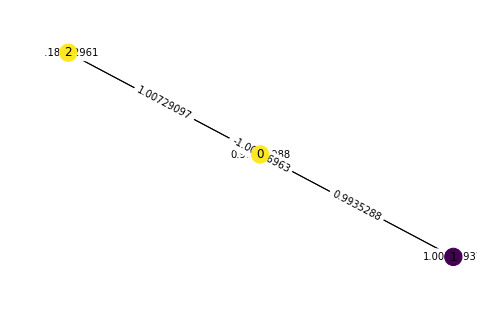

In [14]:
# Number of nodes
n = 3
# Number of partitions (k-cut)
k = 2

# Define min weight and max weight of the graph
min_weight=-1
max_weight=1

# Dropout
dropout = 0

# Create graph and initial partition
W = np.matrix([[ 0.98757988,  0.9998058,   0.99468852], [ 0.9935288,   1.00142937,  0.98883023], [ 1.00729097, -1.00766963,  0.18162961]])

initial_partition = GetKRandomPartition(n, k)
initial_partition = {0: 1, 1: 0, 2: 1}
initial_z = CutCost(W, initial_partition, n, k)

PlotGraph(W, initial_partition)

### Solve local Max-k-cut instance

#### Greedy Best Flip

Greedy Best Flip
Initial cut: 1.9886360299999999
Last cut: 4.0035966300000005
Number of steps: 2
Elapsed time: 0.0 s.



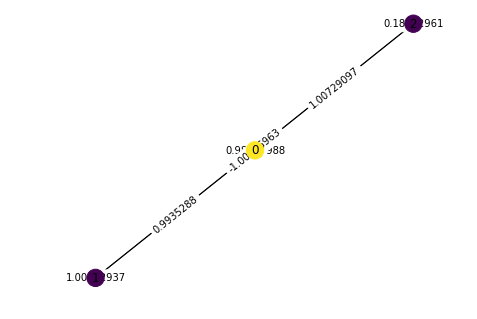

In [16]:
partition, z, elapsed_time, steps = SolveMaxCut(W, n, k, initial_z, initial_partition, "GBF")
print('Greedy Best Flip')
print('Initial cut: ' + str(initial_z))
print('Last cut: ' + str(z))
print('Number of steps: ' + str(steps))
print("Elapsed time: " + str(elapsed_time) + " s.\n")
PlotGraph(W, partition)

#### First Better Flip

First Better Flip
Initial cut: 1.15
Last cut: 1.9899999999999998
Number of steps: 3
Elapsed time: 0.002 s.


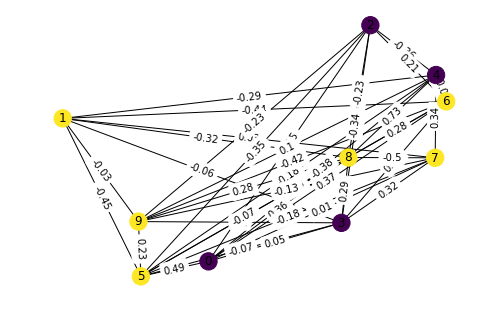

In [477]:
partition, z, elapsed_time, steps = SolveMaxCut(W, n, k, initial_z, initial_partition, "FBF")
print("First Better Flip")
print('Initial cut: ' + str(initial_z))
print('Last cut: ' + str(z))
print('Number of steps: ' + str(steps))
print("Elapsed time: " + str(elapsed_time) + " s.")
PlotGraph(W, partition)

#### Worst Flip

Worst Flip
Initial cut: 1.15
Last cut: 2.09
Number of steps: 5
Elapsed time: 0.004 s.


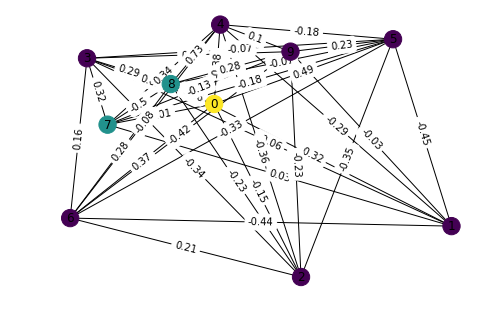

In [478]:
partition, z, elapsed_time, steps = SolveMaxCut(W, n, k, initial_z, initial_partition, "WF")
print("Worst Flip")
print('Initial cut: ' + str(initial_z))
print('Last cut: ' + str(z))
print('Number of steps: ' + str(steps))
print("Elapsed time: " + str(elapsed_time) + " s.")
PlotGraph(W, partition)

#### Random Flip

Random Flip
Initial cut: 1.15
Last cut: 2.09
Number of steps: 4
Elapsed time: 0.003 s.


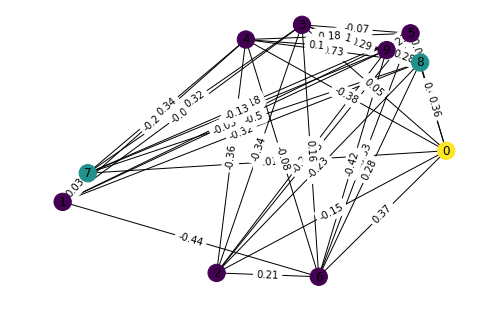

In [479]:
partition, z, elapsed_time, steps = SolveMaxCut(W, n, k, initial_z, initial_partition, "RF")
print("Random Flip")
print('Initial cut: ' + str(initial_z))
print('Last cut: ' + str(z))
print('Number of steps: ' + str(steps))
print("Elapsed time: " + str(elapsed_time) + " s.")
PlotGraph(W, partition)

## Average complexity

### Define main functions

In [481]:
def RunGridMaxCutAverageK(min_nodes, max_nodes, step_nodes, dropout, ks,  min_weight, max_weight, iters_for_nk, method):

    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)

    steps_mean = np.zeros((len(nodes), len(ks)))
    steps_sd = np.zeros((len(nodes), len(ks)))
    
    i = 0
    j = 0

    for ni in nodes:
        for ki in ks:
            steps = np.zeros(iters_for_nk)
            for it in range(iters_for_nk):
                # Create graph and initial partition
                W = InitializeGraph(ni, min_weight, max_weight, dropout)
                initial_partition = GetKRandomPartition(ni, ki)
                # Get initial cost value
                initial_z = CutCost(W, initial_partition, ni, ki)
                # Get next local maximum
                if method == "FirstBetterFlip":
                    partition, z, elapsed_time, n_steps = SolveMaxCut(W, ni, ki, initial_z, initial_partition, "FirstBetterFlip")
                elif method == "GreedyBestFlip":
                    partition, z, elapsed_time, n_steps = SolveMaxCut(W, ni, ki, initial_z, initial_partition, "GreedyBestFlip")
                elif method == "WorstFlip":
                    partition, z, elapsed_time, n_steps = SolveMaxCut(W, ni, ki, initial_z, initial_partition, "WorstFlip")
                elif method == "RandomFlip":
                    partition, z, elapsed_time, n_steps = SolveMaxCut(W, ni, ki, initial_z, initial_partition, "RandomFlip")

                # Save results for each iteration
                steps[it]=n_steps
             
            # Save results for a i,j combination    
            steps_mean[i,j] = np.mean(steps)
            steps_sd[i,j] = np.std(steps)/np.sqrt(iters_for_nk)
            j = j + 1
        j = 0
        i = i + 1
    return steps_mean, steps_sd, nodes

def RunGridMaxCutAverageDropout(min_nodes, max_nodes, step_nodes, dropouts, k, min_weight, max_weight, iters_for_nk, method):

    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)

    steps_mean = np.zeros((len(nodes), len(dropouts)))
    steps_sd = np.zeros((len(nodes), len(dropouts)))
    
    i = 0
    j = 0

    for ni in nodes:
        for d in dropouts:
            steps = np.zeros(iters_for_nk)
            for it in range(iters_for_nk):
                # Create graph and initial partition
                W = InitializeGraph(ni, min_weight, max_weight, d)
                initial_partition = GetKRandomPartition(ni, k)
                # Get initial cost value
                initial_z = CutCost(W, initial_partition, ni, k)
                # Get next local maximum
                if method == "FirstBetterFlip":
                    partition, z, elapsed_time, n_steps = SolveMaxCut(W, ni, k, initial_z, initial_partition, "FirstBetterFlip")
                elif method == "GreedyBestFlip":
                    partition, z, elapsed_time, n_steps = SolveMaxCut(W, ni, k, initial_z, initial_partition, "GreedyBestFlip")
                elif method == "WorstFlip":
                    partition, z, elapsed_time, n_steps = SolveMaxCut(W, ni, k, initial_z, initial_partition, "WorstFlip")
                elif method == "RandomFlip":
                    partition, z, elapsed_time, n_steps = SolveMaxCut(W, ni, k, initial_z, initial_partition, "RandomFlip")

                # Save results for each iteration
                steps[it]=n_steps
                
            # Save results for a i,j combination    
            steps_mean[i,j] = np.mean(steps)
            steps_sd[i,j] = np.std(steps)/np.sqrt(iters_for_nk)
            j = j + 1
        j = 0
        i = i + 1
    return steps_mean, steps_sd, nodes

def RunGridMaxCutAverageHeuristics(min_nodes, max_nodes, step_nodes, dropout, k, min_weight, max_weight, iters_for_nk, heuristics):

    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)

    steps_mean = np.zeros((len(nodes), len(dropouts)))
    steps_sd = np.zeros((len(nodes), len(dropouts)))
    
    i = 0
    j = 0

    for ni in nodes:
        for h in heuristics:
            steps = np.zeros(iters_for_nk)
            for it in range(iters_for_nk):
                # Create graph and initial partition
                W = InitializeGraph(ni, min_weight, max_weight, dropout)
                initial_partition = GetKRandomPartition(ni, k)
                # Get initial cost value
                initial_z = CutCost(W, initial_partition, ni, k)
                # Select method
                partition, z, elapsed_time, n_steps = SolveMaxCut(W, ni, k, initial_z, initial_partition, h)
                # Save results for each iteration
                steps[it]=n_steps
                
            # Save results for a i,j combination    
            steps_mean[i,j] = np.mean(steps)
            steps_sd[i,j] = np.std(steps)/np.sqrt(iters_for_nk)
            j = j + 1
        j = 0
        i = i + 1
    return steps_mean, steps_sd, nodes

### Complete graph

#### Dependency on k

##### Main parameters

In [ ]:
## Define grid parameters
# Nodes
min_nodes = 5
max_nodes = 20
num_nodes = 10

# Dropout assumed to be 0
dropout = 0

# K-cuts
ks=[2, 4, 5]

# Number of instances for each combination
iters_for_nk=20

# Method
method = "FBF"

##### Run

In [422]:
steps_mean, steps_sd, nodes = RunGridMaxCutAverageK(
    min_nodes, max_nodes, num_nodes, dropout, ks, min_weight, max_weight, iters_for_nk, method)

##### Show results

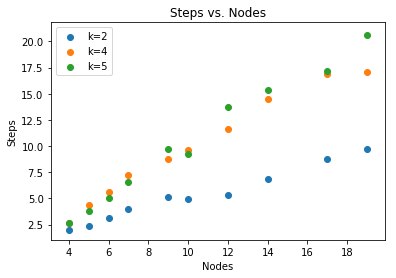

In [423]:
PlotResults(nodes, steps_mean, steps_sd, False, ks, 'k')

##### Polynomial behavior

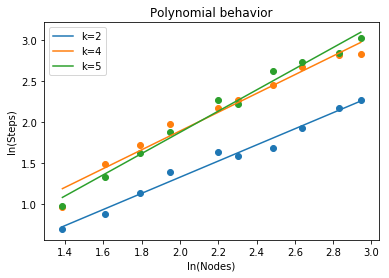

Regression results:

  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    0.988       -0.651      0.990
  4    1.150       -0.409      0.984
  5    1.299       -0.723      0.991


In [426]:
slopes, intercepts = PlotRegressionResults(nodes, steps_mean, steps_sd, False, ks, 'k', "polynomial")

##### Exponential behavior

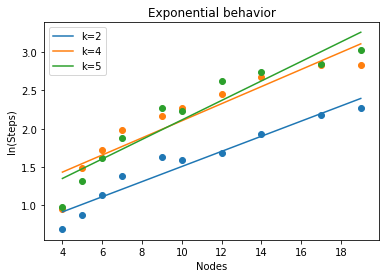

Regression results:

  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    0.099        0.520      0.965
  4    0.112        0.987      0.931
  5    0.127        0.842      0.947


In [427]:
slopes, intercepts = PlotRegressionResults(nodes, steps_mean, steps_sd, False, ks, 'k', "exponential")

#### Dependency on heuristics

##### Main parameters

In [490]:
## Define grid parameters
# Nodes
min_nodes = 5
max_nodes = 100
num_nodes = 20

# Dropout assumed to be 0
dropout = 0

# K-cuts
k=2

# Number of instances for each combination
iters_for_nk=40

# Method
methods = ["FBF", "GBF", "RF", "WF"]

##### Run

In [491]:
steps_mean, steps_sd, nodes = RunGridMaxCutAverageHeuristics(
    min_nodes, max_nodes, num_nodes, dropout, k, min_weight, max_weight, iters_for_nk, methods)

##### Show results

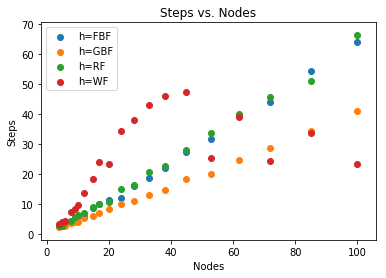

In [492]:
PlotResults(nodes, steps_mean, steps_sd, False, methods, 'h')

##### Polynomial behavior

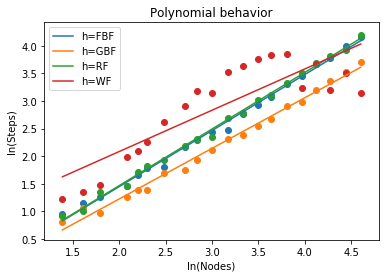

Regression results:

h      slope    intercept    r_value
---  -------  -----------  ---------
FBF    1.015       -0.582      0.997
GBF    0.917       -0.609      0.996
RF     1.026       -0.585      0.998
WF     0.748        0.588      0.853


In [493]:
slopes, intercepts = PlotRegressionResults(nodes, steps_mean, steps_sd, False, methods, 'h', "polynomial")

##### Exponential behavior

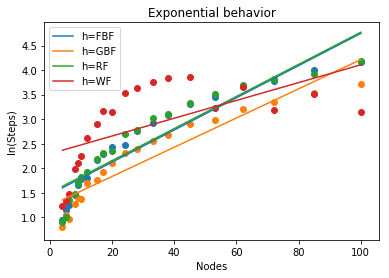

Regression results:

h      slope    intercept    r_value
---  -------  -----------  ---------
FBF    0.033        1.469      0.939
GBF    0.030        1.238      0.943
RF     0.033        1.499      0.929
WF     0.018        2.294      0.603


In [494]:
slopes, intercepts = PlotRegressionResults(nodes, steps_mean, steps_sd, False, methods, 'h', "exponential")

### Partial graph (dropout)

In [469]:
# Define grid parameters
# Nodes
min_nodes = 5
max_nodes = 150
num_nodes = 20

#min_weight and max_weight
min_weight=-1
max_weight=1

# List of dropouts
dropouts = np.round(np.linspace(0.1,0.9,7),2)

# K-cuts
k=8

# Number of instances for each combination
iters_for_nk=20

# Method
method = "FirstBetterFlip"

#### Run FLIP

In [470]:
steps_mean, steps_sd, nodes = RunGridMaxCutAverageDropout(
    min_nodes, max_nodes, num_nodes, dropouts, k, min_weight, max_weight, iters_for_nk, method)

#### Show results

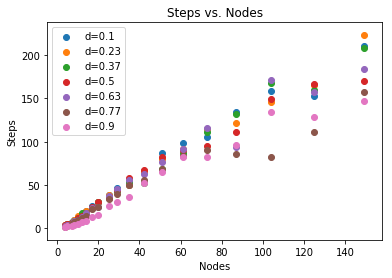

In [471]:
PlotResults(nodes, steps_mean, steps_sd, False, dropouts, 'd')

#### Polynomial behavior

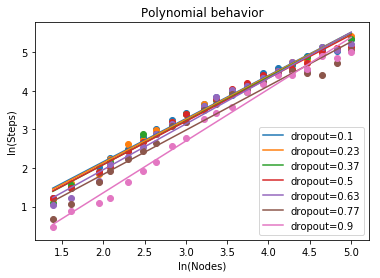

Regression results:

  dropout    slope    intercept    r_value
---------  -------  -----------  ---------
    0.100    1.116       -0.071      0.993
    0.230    1.121       -0.105      0.994
    0.370    1.133       -0.177      0.994
    0.500    1.118       -0.147      0.992
    0.630    1.183       -0.409      0.989
    0.770    1.143       -0.448      0.980
    0.900    1.340       -1.320      0.992


In [472]:
slopes, intercepts = PlotRegressionResults(nodes, steps_mean, steps_sd, False, dropouts, 'dropout', "polynomial")

#### Exponential behavior

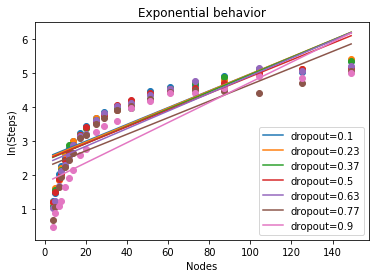

Regression results:

  dropout    slope    intercept    r_value
---------  -------  -----------  ---------
    0.100    0.025        2.496      0.859
    0.230    0.025        2.464      0.868
    0.370    0.025        2.416      0.870
    0.500    0.025        2.432      0.852
    0.630    0.026        2.323      0.848
    0.770    0.024        2.220      0.817
    0.900    0.030        1.764      0.856


In [473]:
slopes, intercepts = PlotRegressionResults(nodes, steps_mean, steps_sd, False, dropouts, 'dropout', "exponential")

## Smoothed complexity

### Complete graph

#### Dependency on k

##### Define main functions

In [98]:
from scipy.optimize import basinhopping

def SmoothedComplexity(W, n, k, dropout, iters_for_nk, method, sigma):
    # Convert to proper shape
    real_shape = int(np.sqrt(len(W)))
    Wi = W.reshape(real_shape, real_shape)
    steps = np.zeros(iters_for_nk)
    for it in range(iters_for_nk):
        # Create initial partition
        W_k_it = Wi + np.random.normal(loc=0, scale=sigma, size=(n,n)) 
        # Copy upper diagonal to lower diagonal (only the upper perturbation counts)
        i_lower = np.tril_indices(n, -1)
        W_k_it[i_lower] = W_k_it.T[i_lower]
        # Make sure that diagonal is 0
        np.fill_diagonal(W_k_it, 0)
        # Perform a dropout
        if dropout>0:
            D = np.random.choice([0,1], size=(n,n), replace=True, p=[dropout, 1-dropout])
            W = np.multiply(W,D)
        # Get initial partition randomly
        initial_partition = GetKRandomPartition(n, k)
        # Get initial cost value
        initial_z = CutCost(W_k_it, initial_partition, n, k)
        # Get next local maximum
        partition, z, elapsed_time, n_steps = SolveMaxCut(W_k_it, n, k, initial_z, initial_partition, method)
        # Save results
        # times += elapsed_time
        steps[it]=n_steps
        # Think of another measure of the gap
    step_means = np.mean(steps)
    
    return -1*step_means

def BasinHoppingSmoothedComplexityK(min_nodes, max_nodes, step_nodes, ks, dropout, 
                                  min_weight, max_weight, iters_for_nk, method, sigma, n_iterations):
    # Create nodes grid
    # nodes = np.linspace(min_nodes, max_nodes, num=step_nodes, dtype=int)
    nodes = np.logspace(np.log(min_nodes), np.log(max_nodes), num=step_nodes, base=np.exp(1))
    # Remove decimal part
    nodes = np.floor(nodes)
    # Convert to integer
    nodes = nodes.astype(int)
    # Store results
    smoothed_complexities = np.zeros((len(nodes), len(ks)))
    
    # Running variables
    i = 0
    j = 0
    
    for ni in nodes:
        # Create boundaries
        bound = (-1., 1.)
        bounds = []
        for m in range(ni*ni):
            bounds.append(bound)
        bounded_step = RandomDisplacementBounds(np.array([b[0] for b in bounds]), np.array([b[1] for b in bounds]))
        for ki in ks:
            #Initial guess
            W0 = InitializeGraph(ni, -1, 1, dropout)
            W0 = W0.flatten()
            # Initialize kwargs
            minimizer_kwargs = {"args": (ni, ki, dropout, iters_for_nk, method, sigma), "bounds": bounds}
            ret = basinhopping(SmoothedComplexity, W0, disp = False, minimizer_kwargs=minimizer_kwargs, niter=n_iterations, take_step=bounded_step)
            smoothed_complexities[i, j] = ret.fun
            j = j + 1
        j = 0
        i = i + 1
    return nodes, -1*smoothed_complexities

class RandomDisplacementBounds(object):
    """random displacement with bounds:  see: https://stackoverflow.com/a/21967888/2320035
        Modified! (dropped acceptance-rejection sampling for a more specialized approach)
    """
    def __init__(self, xmin, xmax, stepsize=0.5):
        self.xmin = xmin
        self.xmax = xmax
        self.stepsize = stepsize

    def __call__(self, x):
        """take a random step but ensure the new position is within the bounds """
        min_step = np.maximum(self.xmin - x, -self.stepsize)
        max_step = np.minimum(self.xmax - x, self.stepsize)

        random_step = np.random.uniform(low=min_step, high=max_step, size=x.shape)
        xnew = x + random_step

        return xnew

##### Define main variables

In [99]:
## Define grid parameters
# Nodes
min_nodes = 5
max_nodes = 50
num_nodes = 10

# Dropout assumed to be 0
dropout = 0

# K-cuts
ks=[2, 3]

# Weights range
min_weight = -1
max_weight = 1

# Perturbation
sigma = 0.1

# Number of instances for each combination
iters_for_nk=20

# Method
method = "FBF"

# n iterations of basinhopping
n_iterations = 2

##### Run

In [92]:
nodes, smoothed_complexities = BasinHoppingSmoothedComplexityK(min_nodes, max_nodes, num_nodes, ks, dropout, 
                                  min_weight, max_weight, iters_for_nk, method, sigma, n_iterations)

0
0
-2.8
0
1
-3.5
1
0
-5.7
1
1
-8.35
2
0
-11.45
2
1
-18.25


##### Show results

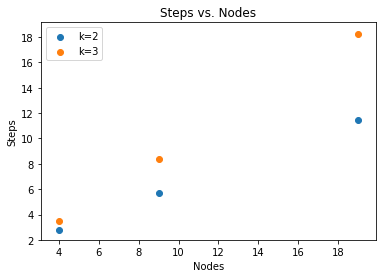

In [100]:
PlotResults(nodes, -1*smoothed_complexities, [], False, ks, 'k')

##### Polynomial behavior

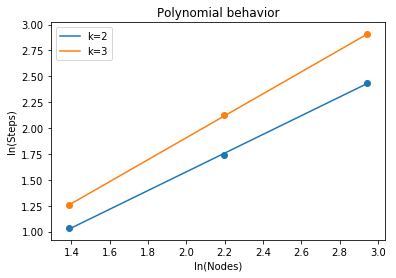

Regression results:

  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    0.903       -0.230      1.000
  3    1.060       -0.214      1.000


In [102]:
slopes, intercepts = PlotRegressionResults(nodes, smoothed_complexities, [], False, ks, 'k', "polynomial")

##### Exponential behavior

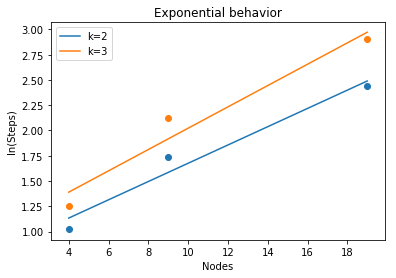

Regression results:

  k    slope    intercept    r_value
---  -------  -----------  ---------
  2    0.090        0.771      0.981
  3    0.106        0.967      0.976


In [103]:
slopes, intercepts = PlotRegressionResults(nodes, smoothed_complexities, [], False, ks, 'k', "exponential")